## Import all libaries

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import random
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn import svm, metrics,preprocessing
#from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,roc_curve, auc,classification_report
from sklearn.model_selection import cross_val_predict
from matplotlib import pyplot as plt
from collections import Counter
from scipy.stats import norm
import seaborn as sns; sns.set(font_scale=1.2)
%matplotlib inline
import time
import xgboost as xgb
import lightgbm as lgb

### REading WESAD data

In [2]:
preprocess_path=r'C:/Users/Sultan/OneDrive - Middle Tennessee State University/Courses/Fall23/CSCI_6330/Project/WESAD/preprocess_data/'
## Reading the all subject data 
# dfall_read_seq= pd.read_pickle("./dfallfnir.pkl")
dfall_read_seq=pd.read_json(preprocess_path+'dfallwesad630.json', orient ='split', compression = 'infer')
## Shuffle the data.
dfall_read1=dfall_read_seq.sample(frac=1,random_state=42)
# dfall_read=dfall_read_seq.copy()
dfall_read1.rename(columns={'label': 'label3'}, inplace=True)
dfall_read1
def convert_slither(df):
    return 1 if df['label3'] == 2 else 0
dfall_read1['label'] = dfall_read1.apply(convert_slither, axis=1)
dfall_read=dfall_read1.drop(columns=['label3'])
dfall_read

,ECG_mean,ECG_std,ECG_min,ECG_max,ECG_kur,ECG_skew,EDA_mean,EDA_std,EDA_min,EDA_max,...,Resp_max,Resp_kur,Resp_skew,Temp_mean,Temp_std,Temp_min,Temp_max,Temp_kur,Temp_skew,label
12093,2.404566,0.007982,2.389526,2.458191,2.458191,2.458191,33.926754,0.022778,33.862762,34.037689,...,0.029251,0.029251,0.029251,-3.047594,0.412165,-3.765869,-1.881409,-1.881409,-1.881409,0
15253,5.319847,0.006806,5.300522,5.374908,5.374908,5.374908,33.303738,0.017777,33.248535,33.390289,...,0.041656,0.041656,0.041656,-2.949335,0.257183,-3.617859,-2.212524,-2.212524,-2.212524,0
33538,3.839169,0.007844,3.805542,3.879166,3.879166,3.879166,35.085701,0.032082,34.992676,35.190491,...,0.044083,0.044083,0.044083,5.726406,1.179052,2.543640,7.127380,7.127380,7.127380,1
24990,4.024520,0.010274,3.981018,4.132843,4.132843,4.132843,34.634609,0.029546,34.552673,34.761536,...,0.029022,0.029022,0.029022,-1.770150,0.155509,-2.397156,-1.397705,-1.397705,-1.397705,0
30136,11.254581,0.010879,11.186981,11.316299,11.316299,11.316299,34.482311,0.026818,34.405579,34.601746,...,0.030121,0.030121,0.030121,1.912631,1.969689,-1.206970,5.104065,5.104065,5.104065,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,7.260228,0.006452,7.240677,7.301712,7.301712,7.301712,34.428383,0.025490,34.347473,34.518951,...,0.019638,0.019638,0.019638,-1.237793,1.343410,-3.712463,1.681519,1.681519,1.681519,1
6265,2.386311,0.012563,2.366638,2.528000,2.528000,2.528000,33.932236,0.023062,33.865784,34.036163,...,0.025497,0.025497,0.025497,1.992788,0.525431,0.758362,2.629089,2.629089,2.629089,0
11284,3.317247,0.009020,3.246307,3.453827,3.453827,3.453827,34.128056,0.024947,34.057465,34.246582,...,0.033554,0.033554,0.033554,4.916999,0.929202,3.633118,8.308411,8.308411,8.308411,1
860,0.802228,0.012447,0.777435,0.864410,0.864410,0.864410,34.348511,0.025660,34.271027,34.399475,...,0.021561,0.021561,0.021561,-0.238151,1.511022,-2.479553,2.745056,2.745056,2.745056,0


### Checking any duplicate data/samples

In [3]:
dfall_read.duplicated().sum()

0

## Count the 0 and 3 class labels

In [4]:
dfall_read.label.value_counts()

0    25751
1    11067
Name: label, dtype: int64

In [5]:
# dfall_read_seq.label.value_counts()

#####  Preprocessing (e.g., scaling, split traing and test data set)
+ checking

In [6]:
## copy the initial read data to dfall
dfall=dfall_read.copy()
## Separtae the features for all exaples (0-back and 3-back)
Xc=dfall.iloc[:,0:-1].values
## Separte the class labels
y=dfall.iloc[:,-1].values
## Preprocsiing for normalizing all the features with 0 mean and 1 standard deviation
X=preprocessing.scale(Xc)
## Spliting the training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.20, random_state=42) 
## Checking the number of each class in the traing data
print(np.unique(y_train,return_counts=True))
## Checking the number of each class in the test data
print(np.unique(y_test,return_counts=True))

(array([0, 1], dtype=int64), array([20668,  8786], dtype=int64))
(array([0, 1], dtype=int64), array([5083, 2281], dtype=int64))


## Customized function for pre-processing

In [7]:
def preprocess_scaling(df):
    '''df:df is the dataframe where the feature start from first columns and last colunm is label
    There are 4 returns : X_train, X_test, y_train, y_test'''
    Xc=df.iloc[:,0:-1].values
    y=df.iloc[:,-1].values
    X=preprocessing.scale(Xc)
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.20, random_state=42) 
    np.unique(y_test,return_counts=True)
    return X_train, X_test, y_train, y_test

### Csutomized function for cross validation 

In [8]:
def crossvalidate_classifier(model,X,y,cv):
    '''model: classifier, 
    X: Feature vector,
    y: class label
    cv: how many cross validation
    '''
    print('The model name is:',model)
#     model.fit(X, y)
    ## Performaing cross validation
    cv_scores = cross_val_score(model, X, y, cv=cv)
    print(cv_scores)
    ## Printing the results with two decimal floating points 
    print("%0.2f f-1 score with a standard deviation of %0.2f" % (cv_scores.mean(), cv_scores.std()))
    print('cv_scores mean:{}'.format(np.mean(cv_scores)))
    ## Generating the cross validation prediction
    y_pred = cross_val_predict(model, X, y, cv=cv)
    ## making confusion matrix y: true/groundtruth; y_pred: model predicted 
    cm = confusion_matrix(y, y_pred)
    print (cm)
    ## Compute the accuracy
    acc = accuracy_score(y, y_pred)
    print("Accuracy Score:   %0.8f" % acc)
    ## AUC scores
    fpr, tpr, thre_sholds = metrics.roc_curve(y,y_pred,pos_label=3)
    auc=metrics.auc(fpr, tpr)
    print("AUC Score:   %0.8f" % auc)
    ## Prepare the classification report
    cls_rep=classification_report(y, y_pred)
#     f1score = metrics.f1_score(y_pred, y_test)
    print(cls_rep)
    ## plot the cionfusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues,values_format='g')
    plt.grid(b=None)
    plt.show()

### Csutomized function for evaluating results on test data

In [9]:
def evaluate_classifier_test_data(model,X_train, X_test, y_train, y_test):
    ''' This is the customized function for tarining the model by training data and evalute the performance on test data 
    model: classifier name,
    X_train: Training features vector,
    X_test: Test Feature vector,
    y_train: Training class label,
    y_test: Test class label (ground truth test data)
    '''
    print('The results on test data for:',model)
    model.fit(X_train, y_train)
    ## Predict
    y_pred = model.predict(X_test)
    #from sklearn.metrics import confusion_matrix, accuracy_score
    cm = confusion_matrix(y_test, y_pred)
    print (cm)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy Score:   %0.8f" % acc)
    ## AUC scores
    fpr, tpr, thre_sholds = metrics.roc_curve(y_test,y_pred,pos_label=3)
    auc=metrics.auc(fpr, tpr)
    print("AUC Score:   %0.8f" % auc)
    ## Prepare the classification report
    cls_rep=classification_report(y_test, y_pred)
#     f1score = metrics.f1_score(y_pred, y_test)
    print(cls_rep)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues,values_format='g',ax=None)
    plt.grid(False)  # To hide grid lines
    plt.show()

In [10]:
dfall.head(5)

,ECG_mean,ECG_std,ECG_min,ECG_max,ECG_kur,ECG_skew,EDA_mean,EDA_std,EDA_min,EDA_max,...,Resp_max,Resp_kur,Resp_skew,Temp_mean,Temp_std,Temp_min,Temp_max,Temp_kur,Temp_skew,label
12093,2.404566,0.007982,2.389526,2.458191,2.458191,2.458191,33.926754,0.022778,33.862762,34.037689,...,0.029251,0.029251,0.029251,-3.047594,0.412165,-3.765869,-1.881409,-1.881409,-1.881409,0
15253,5.319847,0.006806,5.300522,5.374908,5.374908,5.374908,33.303738,0.017777,33.248535,33.390289,...,0.041656,0.041656,0.041656,-2.949335,0.257183,-3.617859,-2.212524,-2.212524,-2.212524,0
33538,3.839169,0.007844,3.805542,3.879166,3.879166,3.879166,35.085701,0.032082,34.992676,35.190491,...,0.044083,0.044083,0.044083,5.726406,1.179052,2.543640,7.127380,7.127380,7.127380,1
24990,4.024520,0.010274,3.981018,4.132843,4.132843,4.132843,34.634609,0.029546,34.552673,34.761536,...,0.029022,0.029022,0.029022,-1.770150,0.155509,-2.397156,-1.397705,-1.397705,-1.397705,0
30136,11.254581,0.010879,11.186981,11.316299,11.316299,11.316299,34.482311,0.026818,34.405579,34.601746,...,0.030121,0.030121,0.030121,1.912631,1.969689,-1.206970,5.104065,5.104065,5.104065,0


## KNN Classifier

The results on test data for: KNeighborsClassifier(n_neighbors=2, weights='distance')
[[4980  103]
 [ 144 2137]]
Accuracy Score:   0.96645845
AUC Score:   nan
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5083
           1       0.95      0.94      0.95      2281

    accuracy                           0.97      7364
   macro avg       0.96      0.96      0.96      7364
weighted avg       0.97      0.97      0.97      7364



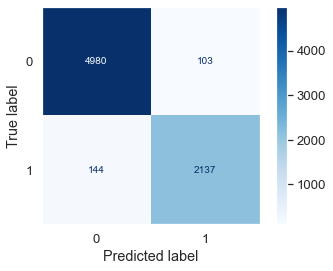

Time taken: 2.228724241256714


In [11]:
st=time.time()
# knn_model = KNeighborsClassifier(metric='manhattan', n_neighbors=2, weights='distance')
knn_model = KNeighborsClassifier(metric='minkowski', n_neighbors=2, weights='distance',p=2)
X_train, X_test, y_train, y_test=preprocess_scaling(dfall)
evaluate_classifier_test_data(knn_model,X_train, X_test, y_train, y_test)
# evaluate_classifier_test_data(knn_model,X_train, X_test, y_train, y_test)
print("Time taken:",(time.time()-st))

### Decision Tree

The results on test data for: DecisionTreeClassifier(criterion='entropy', max_depth=50)
[[5020   63]
 [  77 2204]]
Accuracy Score:   0.98098859
AUC Score:   nan
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5083
           1       0.97      0.97      0.97      2281

    accuracy                           0.98      7364
   macro avg       0.98      0.98      0.98      7364
weighted avg       0.98      0.98      0.98      7364



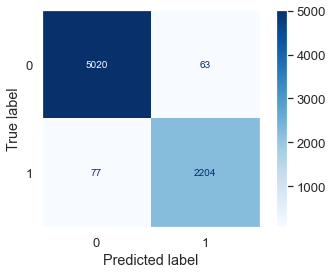

Time taken: 3.0857434272766113


In [12]:
st=time.time()
dtc_model = DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=50)
X_train, X_test, y_train, y_test=preprocess_scaling(dfall)
##Evaluate the model performace on test data
evaluate_classifier_test_data(dtc_model,X_train, X_test, y_train, y_test)
print("Time taken:",(time.time()-st))

### XGBoost 

The results on test data for: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.7,
              enable_categorical=False, eval_metric='logloss', gamma=0.2,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_delta_step=None, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
[[5071   12]
 [  15 2266]]
Accuracy Score:   0.99633351
AUC Score:   nan
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5083
           1       0.99      0.99      0.99      2281

    accuracy                      

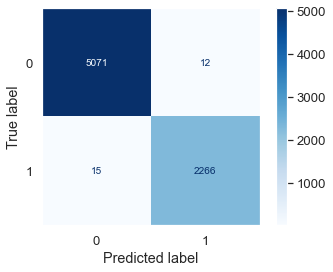

Time taken: 11.332514524459839


In [13]:
st=time.time()
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', random_state=42,min_child_weight= 1, 
                            max_depth= 15, learning_rate= 0.3,
                            gamma= 0.2, colsample_bytree= 0.7,eval_metric= 'logloss')
# params= {'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.2, 'colsample_bytree': 0.7}
##Evaluate the model performace on test data
evaluate_classifier_test_data(xgb_clf,X_train, X_test, y_train, y_test)
print("Time taken:",(time.time()-st))

## LightGBM

The results on test data for: LGBMClassifier(colsample_bytree=0.7, learning_rate=0.3, max_depth=100,
               min_child_weight=0.5, n_estimators=200)
[[5073   10]
 [  11 2270]]
Accuracy Score:   0.99714829
AUC Score:   nan
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5083
           1       1.00      1.00      1.00      2281

    accuracy                           1.00      7364
   macro avg       1.00      1.00      1.00      7364
weighted avg       1.00      1.00      1.00      7364



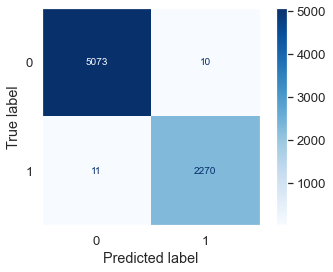

Time taken: 2.093801975250244


In [14]:
st=time.time()
## Classifier
lgb_clf = lgb.LGBMClassifier(colsample_bytree=0.7, learning_rate=0.3, max_depth=100,min_child_weight=0.5, n_estimators=200)
## Preprocessing spliting traing and test data
X_train, X_test, y_train, y_test=preprocess_scaling(dfall)
##Evaluate the model performace on test data
evaluate_classifier_test_data(lgb_clf,X_train, X_test, y_train, y_test)
print("Time taken:",(time.time()-st))

## Random Forest

The results on test data for: RandomForestClassifier(max_depth=40, max_features='log2', n_estimators=200)
[[5065   18]
 [  17 2264]]
Accuracy Score:   0.99524715
AUC Score:   nan
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5083
           1       0.99      0.99      0.99      2281

    accuracy                           1.00      7364
   macro avg       0.99      0.99      0.99      7364
weighted avg       1.00      1.00      1.00      7364



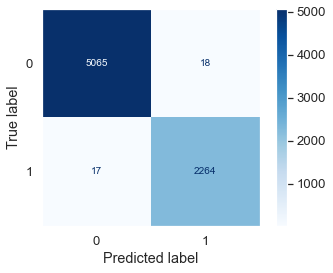

Time taken: 56.42406606674194


In [15]:
st=time.time()
rf_model = RandomForestClassifier(max_depth=40, max_features='log2', n_estimators=200)
X_train, X_test, y_train, y_test=preprocess_scaling(dfall)
##Evaluate the model performace on test data
evaluate_classifier_test_data(rf_model,X_train, X_test, y_train, y_test)
print("Time taken:",(time.time()-st))

## SVM

The results on test data for: SVC(C=10, gamma=0.1)
[[5022   61]
 [  77 2204]]
Accuracy Score:   0.98126018
AUC Score:   nan
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5083
           1       0.97      0.97      0.97      2281

    accuracy                           0.98      7364
   macro avg       0.98      0.98      0.98      7364
weighted avg       0.98      0.98      0.98      7364



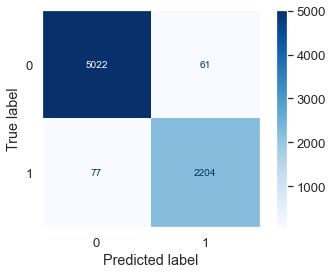

Time taken: 59.22409462928772


In [16]:
st=time.time()
svm_model = svm.SVC(C=10, kernel='rbf',degree=3,gamma=0.1)
X_train, X_test, y_train, y_test=preprocess_scaling(dfall)
##Evaluate the model performace on test data
evaluate_classifier_test_data(svm_model,X_train, X_test, y_train, y_test)
print("Time taken:",(time.time()-st))

### Summary results plot

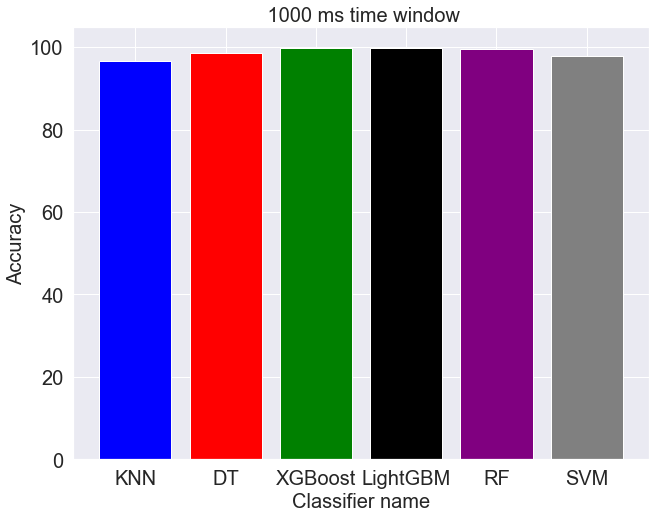

In [17]:
axis_font = {'fontname':'Arial', 'size':'20'}
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0,0,1,1])
# fig, ax = plt.subplots()
Models = ['KNN','DT','XGBoost','LightGBM', 'RF', 'SVM']
accuracy_full = [96.65,98.61,99.69,99.81,99.61,97.79 ]
ax.bar(Models,accuracy_full)
ax.set_ylabel('Accuracy',**axis_font)
ax.set_xlabel('Classifier name',**axis_font)
plt.bar(Models, accuracy_full, color=['blue', 'red', 'green','black','purple','gray'])
plt.title(' 1000 ms time window',**axis_font)
plt.xticks(**axis_font)
plt.yticks(**axis_font)
# plt.rcParams.update({'font.size':30})
plt.tight_layout()
plt.savefig('Fig_3_WholeBrain.eps')
plt.show()

In [18]:
# 700/4*5

## ----------------------The End---------------------